#### objective
2. re-read paper and understand "online-training" and other technical nuances
3. think about data (figure out alpha advantage)
4. (lower priority) set up AWS

- move to tensorflow 2.0
- expand state variable to consider factors, price, positions and cash
- add action to rotate into other asset class
- consider learning quantity too
- include lstm for forecasting returns
- 

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorflow.python.framework import ops
sns.set()

In [2]:
df_hsi = pd.read_csv('^HSI.csv')[['Date', 'Adj Close']]
df_spx = pd.read_csv('^GSPC.csv')[['Date', 'Adj Close']]
df_hsi.rename(columns={'Adj Close':'hsi'}, inplace=True)
df_spx.rename(columns={'Adj Close':'spx'}, inplace=True)
df = df_hsi.merge(df_spx, on='Date').dropna()

In [3]:
df = pd.read_csv('^GSPC.csv')[['Date', 'Close']]
df

,Date,Close
0,2001-01-02,1283.270020
1,2001-01-03,1347.560059
2,2001-01-04,1333.339966
3,2001-01-05,1298.349976
4,2001-01-08,1295.859985
...,...,...
3768,2015-12-24,2060.989990
3769,2015-12-28,2056.500000
3770,2015-12-29,2078.360107
3771,2015-12-30,2063.360107


In [4]:
import random
random.randrange(3)

0

In [14]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.9997 # discount factor
        self.epsilon = 0.2
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

#         tf.reset_default_graph()
#         self.sess = tf.InteractiveSession()
#         self.X = tf.placeholder(tf.float32, [None, self.state_size])
#         self.Y = tf.placeholder(tf.float32, [None, self.action_size])
#         feed = tf.nn.rnn_cell.LSTMCell(256, activation = tf.nn.relu)(self.X) # LSTM not working
#         self.logits = tf.layers.dense(feed, self.action_size)
#         self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
#         self.optimizer = tf.train.AdamOptimizer(1e-6).minimize(
#             self.cost
#         )
#         self.sess.run(tf.global_variables_initializer())
        
        self.model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2),
#           tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128, activation='softmax')
        ])

        self.model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    def act(self, state):
        if random.random() <= self.epsilon: # epsilon-greedy 50% chance to act
            return random.randrange(self.action_size) # randomly pick 1 out of 3 actions
        return np.argmax(#model.evaluate(x_test,  y_test, verbose=2)
            self.model.evaluate(self.X, feed_dict = {self.X: state})[0] # pick action that maximizes logits (through forward pass)
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1 # window start
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1] # trend within window
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i]) # DoD price appreciation
        return np.array([res]) # return state = list of price appreciations in time window t 

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory) # length of memory
        for i in range(l - batch_size, l): # iterate over batch size
            mini_batch.append(self.memory[i]) # mini_batch is a list of memories
        replay_size = len(mini_batch) 
        X = np.empty((replay_size, self.state_size)) # X=# mini_batch x state_size
        Y = np.empty((replay_size, self.action_size)) # Y=# mini_batch x action_size
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states}) # feed states to forward pass => Q
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states}) # feed new states to forward pass => new Q
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i] # mini_batch = state, action, reward, new state, done
            target = Q[i] # Q is target
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i]) # bellman equation
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y} # optimization step
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # epsilon decays by 0.001 in each replay untill falls below 0.1
        return cost 
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window): # buy
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t) # register buy timestamp t
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory): # sell
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t) # register sell timestamp t
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment return %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100 # total return 
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size) # batch_size is # of lookback days from time t. in batch_size window, the decisions are optimized day by day
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [15]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 256
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 10, checkpoint = 10, initial_money = initial_money)

AttributeError: 'Agent' object has no attribute 'sess'

In [34]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 12: buy 1 unit at price 1342.540039, total balance 8657.459961
day 14: buy 1 unit at price 1360.400024, total balance 7297.059937
day 16: buy 1 unit at price 1357.510010, total balance 5939.549927
day 17, sell 1 unit at price 1354.949951, investment 0.924361 %, total balance 7294.499878,
day 18, sell 1 unit at price 1364.170044, investment 0.277126 %, total balance 8658.669922,
day 19, sell 1 unit at price 1373.729980, investment 1.194832 %, total balance 10032.399902,
day 28: buy 1 unit at price 1330.310059, total balance 8702.089843
day 29, sell 1 unit at price 1318.800049, investment -0.865213 %, total balance 10020.889892,
day 33: buy 1 unit at price 1278.939941, total balance 8741.949951
day 34, sell 1 unit at price 1255.270020, investment -1.850745 %, total balance 9997.219971,
day 48: buy 1 unit at price 1197.660034, total balance 8799.559937
day 50: buy 1 unit at price 1173.560059, total balance 7625.999878
day 52: buy 1 unit at price 1170.810059, total balance 6455.189819


day 441: buy 1 unit at price 798.549988, total balance 8752.179628
day 442, sell 1 unit at price 776.760010, investment -2.728693 %, total balance 9528.939638,
day 443: buy 1 unit at price 803.919983, total balance 8725.019655
day 445: buy 1 unit at price 841.440002, total balance 7883.579653
day 446, sell 1 unit at price 881.270020, investment 9.621609 %, total balance 8764.849673,
day 447, sell 1 unit at price 860.020020, investment 2.208122 %, total balance 9624.869693,
day 456: buy 1 unit at price 882.150024, total balance 8742.719669
day 457, sell 1 unit at price 890.710022, investment 0.970356 %, total balance 9633.429691,
day 458: buy 1 unit at price 885.760010, total balance 8747.669681
day 460, sell 1 unit at price 908.349976, investment 2.550348 %, total balance 9656.019657,
day 484: buy 1 unit at price 892.000000, total balance 8764.019657
day 485, sell 1 unit at price 904.450012, investment 1.395741 %, total balance 9668.469669,
day 488: buy 1 unit at price 889.479980, tota

day 850: buy 1 unit at price 1095.410034, total balance 8483.189334
day 851, sell 1 unit at price 1113.050049, investment 1.610357 %, total balance 9596.239383,
day 853: buy 1 unit at price 1121.280029, total balance 8474.959354
day 854, sell 1 unit at price 1120.680054, investment -0.053508 %, total balance 9595.639408,
day 859: buy 1 unit at price 1140.420044, total balance 8455.219364
day 860: buy 1 unit at price 1142.180054, total balance 7313.039310
day 861: buy 1 unit at price 1131.329956, total balance 6181.709354
day 864, sell 1 unit at price 1132.010010, investment -0.737451 %, total balance 7313.719364,
day 865, sell 1 unit at price 1133.560059, investment -0.754697 %, total balance 8447.279423,
day 867, sell 1 unit at price 1135.020020, investment 0.326170 %, total balance 9582.299443,
day 886: buy 1 unit at price 1101.390015, total balance 8480.909428
day 888: buy 1 unit at price 1108.670044, total balance 7372.239384
day 889, sell 1 unit at price 1093.880005, investment -0

day 1235: buy 1 unit at price 1264.670044, total balance 8432.338626
day 1236, sell 1 unit at price 1265.079956, investment 0.032413 %, total balance 9697.418582,
day 1240: buy 1 unit at price 1255.839966, total balance 8441.578616
day 1241, sell 1 unit at price 1259.369995, investment 0.281089 %, total balance 9700.948611,
day 1249: buy 1 unit at price 1262.790039, total balance 8438.158572
day 1250, sell 1 unit at price 1268.119995, investment 0.422078 %, total balance 9706.278567,
day 1255: buy 1 unit at price 1248.290039, total balance 8457.988528
day 1257, sell 1 unit at price 1273.459961, investment 2.016352 %, total balance 9731.448489,
day 1266: buy 1 unit at price 1277.930054, total balance 8453.518435
day 1268, sell 1 unit at price 1261.489990, investment -1.286460 %, total balance 9715.008425,
day 1271: buy 1 unit at price 1264.680054, total balance 8450.328371
day 1272: buy 1 unit at price 1273.829956, total balance 7176.498415
day 1273, sell 1 unit at price 1283.719971, in

day 1976, sell 1 unit at price 898.950012, investment -0.655335 %, total balance 9631.397764,
day 1979: buy 1 unit at price 873.289978, total balance 8758.107786
day 1980, sell 1 unit at price 850.750000, investment -2.581042 %, total balance 9608.857786,
day 1982: buy 1 unit at price 806.580017, total balance 8802.277769
day 1983, sell 1 unit at price 752.440002, investment -6.712293 %, total balance 9554.717771,
day 1984: buy 1 unit at price 800.030029, total balance 8754.687742
day 1985, sell 1 unit at price 851.809998, investment 6.472253 %, total balance 9606.497740,
day 1996: buy 1 unit at price 899.239990, total balance 8707.257750
day 1999, sell 1 unit at price 868.570007, investment -3.410656 %, total balance 9575.827757,
day 2000: buy 1 unit at price 913.179993, total balance 8662.647764
day 2001, sell 1 unit at price 904.419983, investment -0.959286 %, total balance 9567.067747,
day 2005: buy 1 unit at price 863.159973, total balance 8703.907774
day 2006, sell 1 unit at pric

day 2584, sell 1 unit at price 1314.160034, investment -1.385979 %, total balance 9681.257745,
day 2586: buy 1 unit at price 1314.520020, total balance 8366.737725
day 2587, sell 1 unit at price 1319.680054, investment 0.392541 %, total balance 9686.417779,
day 2592: buy 1 unit at price 1335.250000, total balance 8351.167779
day 2593, sell 1 unit at price 1347.239990, investment 0.897958 %, total balance 9698.407769,
day 2595: buy 1 unit at price 1360.479980, total balance 8337.927789
day 2597, sell 1 unit at price 1361.219971, investment 0.054392 %, total balance 9699.147760,
day 2599: buy 1 unit at price 1347.319946, total balance 8351.827814
day 2602: buy 1 unit at price 1346.290039, total balance 7005.537775
day 2603: buy 1 unit at price 1357.160034, total balance 5648.377741
day 2604, sell 1 unit at price 1342.079956, investment -0.388920 %, total balance 6990.457697,
day 2606, sell 1 unit at price 1337.770020, investment -0.632852 %, total balance 8328.227717,
day 2607, sell 1 un

day 2992, sell 1 unit at price 1406.290039, investment 3.412804 %, total balance 10269.067808,
day 2994: buy 1 unit at price 1409.930054, total balance 8859.137754
day 2995, sell 1 unit at price 1415.949951, investment 0.426964 %, total balance 10275.087705,
day 3001: buy 1 unit at price 1418.069946, total balance 8857.017759
day 3004: buy 1 unit at price 1428.479980, total balance 7428.537779
day 3006, sell 1 unit at price 1413.579956, investment -0.316627 %, total balance 8842.117735,
day 3007, sell 1 unit at price 1430.359985, investment 0.131609 %, total balance 10272.477720,
day 3014: buy 1 unit at price 1418.099976, total balance 8854.377744
day 3016: buy 1 unit at price 1426.189941, total balance 7428.187803
day 3017, sell 1 unit at price 1462.420044, investment 3.125313 %, total balance 8890.607847,
day 3018, sell 1 unit at price 1459.369995, investment 2.326482 %, total balance 10349.977842,
day 3030: buy 1 unit at price 1492.560059, total balance 8857.417783
day 3031, sell 1 

day 3328, sell 1 unit at price 1857.619995, investment 0.273132 %, total balance 10665.458190,
day 3331: buy 1 unit at price 1890.900024, total balance 8774.558166
day 3333, sell 1 unit at price 1865.089966, investment -1.364962 %, total balance 10639.648132,
day 3335: buy 1 unit at price 1851.959961, total balance 8787.688171
day 3339, sell 1 unit at price 1830.609985, investment -1.152831 %, total balance 10618.298156,
day 3343: buy 1 unit at price 1871.890015, total balance 8746.408141
day 3345: buy 1 unit at price 1875.390015, total balance 6871.018126
day 3347, sell 1 unit at price 1863.400024, investment -0.453552 %, total balance 8734.418150,
day 3348, sell 1 unit at price 1869.430054, investment -0.317798 %, total balance 10603.848204,
day 3349: buy 1 unit at price 1878.329956, total balance 8725.518248
day 3351, sell 1 unit at price 1883.680054, investment 0.284833 %, total balance 10609.198302,
day 3353: buy 1 unit at price 1884.660034, total balance 8724.538268
day 3354: buy

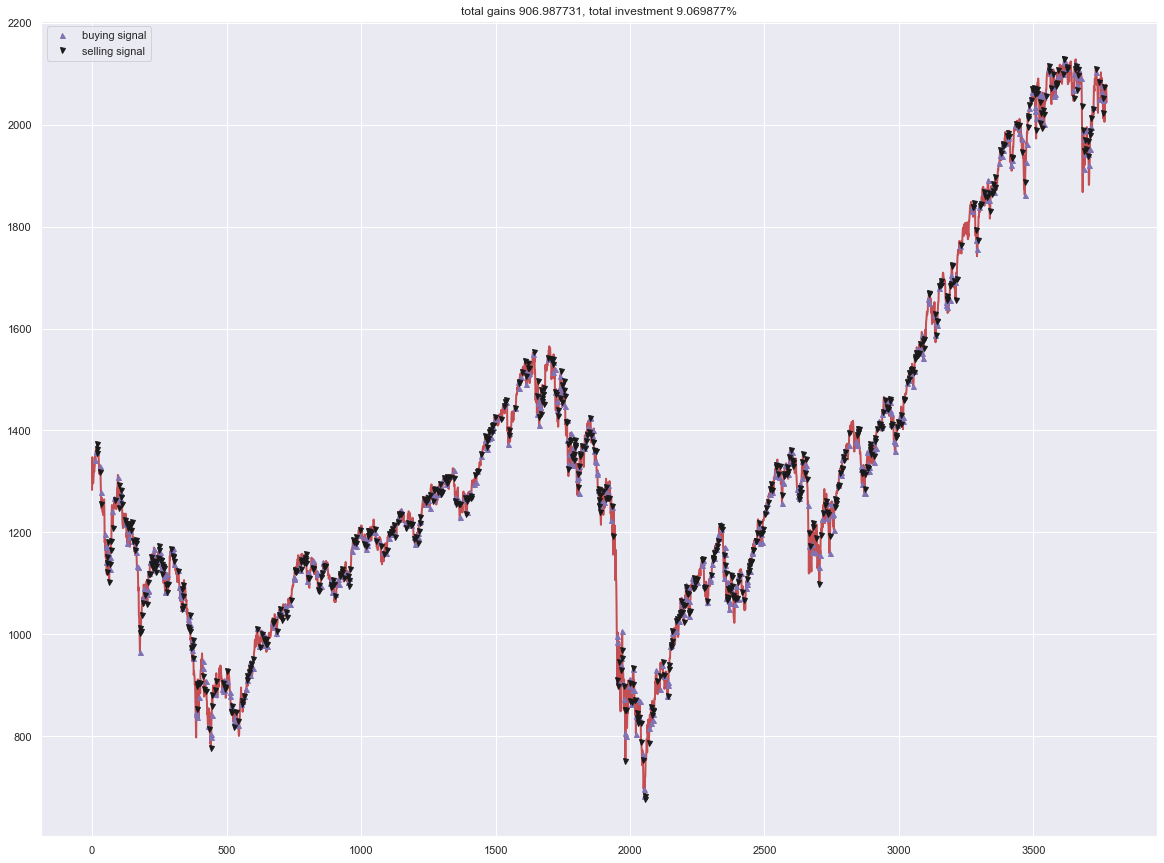

In [39]:
fig = plt.figure(figsize = (20,15))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=5, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=5, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()
